<a href="https://colab.research.google.com/github/Tran-Thu-Le/ttlblog/blob/main/math/ellipse/211001_intersection_of_ellipses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from math import pi


In [2]:

class Ellipse:

    def __init__(self, center, matrix):
        m = matrix.shape[0]
        assert matrix.shape==(m, m) and center.shape ==(m, 1)
        assert matrix.dtype==torch.float64 and center.dtype == torch.float64
        self.center = center 
        self.matrix = matrix 
        eigs, vecs = torch.linalg.eig(self.matrix)
        self.eigs = eigs.real
        self.vecs = vecs.real
        self.dim = m
    
    # ATTRIBUTES
    def mat_sqrt(self):
        return self.vecs @ torch.diag(self.eigs.sqrt()) @ self.vecs.T

    def mat_inv(self):
        return self.vecs @ torch.diag(1/self.eigs) @ self.vecs.T

    def radius(self):
        return self.eigs.max().sqrt()

    def volume(self):
        logdet = torch.logdet(self.matrix)
        m = self.matrix.shape[0]
        log_beta_n = .5 * m * torch.log(torch.tensor(pi)) - torch.lgamma(torch.tensor(.5 * m + 1.)) 
        out = torch.exp( log_beta_n + .5 * logdet )
        return out

    def balance(self):
        return self.eigs.max().sqrt() - self.eigs.min().sqrt()

    # TOOLS    
    def new_ellipse(self, g, lbd):
        c = self.center 
        mat = self.matrix 

        m = mat.shape[0]
        g_norm_2 = (g * (mat @ g)).sum()
        g_norm = g_norm_2.sqrt()
        h =  (g.T @ c).squeeze()-lbd
        alpha = h/g_norm 
        # print(f"ellipse 14: h={h} g_norm^2={g_norm_2} g_norm={g_norm} alpha={alpha}")
        if alpha.abs()<=1.:
            g_bar = g/g_norm 
            delta_1 = (1+alpha*m)/(m+1)
            delta_2 = (m**2*(1-alpha**2))/(m**2-1)
            delta_3 = (2*(1+alpha*m))/((m+1)*(1+alpha))
            c2 = c - delta_1 * mat @ g_bar
            g_mat = g_bar @ g_bar.T
            mat2 = delta_2*(mat - delta_3 * mat @ g_mat @ mat)
            ell =  Ellipse(c2, mat2)
            ell.alpha = alpha
            infor = {
                "alpha": alpha,
                "change": True,
            }
            return ell, infor
        else:
            infor = {
                "alpha": alpha,
                "change": False,
            }
            return self, infor

    def get_point(self, p):
        """
            get the intersection point of ellipse
            and segment joining p and ellipse's center.
        """
        assert p.shape==(self.dim, 1) 
        g = p - self.center 
        vec = g/ (g * (self.mat_inv() @ g)).sum().sqrt()
        return self.center + vec 

    def get_tangent_plane(self, p):
        """
            p must be a tangent point
        """
        assert p.shape==(self.dim, 1)
        g = self.mat_inv() @ (p-self.center)
        level = 1. + (g*self.center).sum()
        return g, level

    def intersect_ellipse(self, ell):
        assert self.dim == ell.dim 
        point = ell.get_point(self.center)
        g, level = ell.get_tangent_plane(point)
        ell_new, _ = self.new_ellipse(g, level)
        return ell_new

    # 2D PLOTTING TOOLs
    def plot_tangent_plane(self, p, ax, xmin, xmax, **kwargs):
        """
            p must be a tangent point
        """
        g, level = self.get_tangent_plane(p)
        a = (level-g[0][0]*xmin)/g[1][0]
        b = (level-g[0][0]*xmax)/g[1][0]
        ax.plot([xmin, xmax], [a, b], **kwargs)

    def plot(self, ax, **kwargs):
        t = 2*pi*torch.linspace(0., 1., 100, dtype = torch.float64)
        x, y = torch.cos(t), torch.sin(t)
        x2, y2 = self.center + self.mat_sqrt() @ torch.cat([x, y]).reshape(2, -1)
        ax.plot(x2, y2, **kwargs)


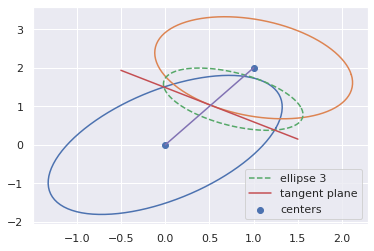

In [3]:
def test():
    alpha = torch.tensor(2*pi/6, dtype=torch.float64 )
    cos, sin = torch.cos(alpha), torch.sin(alpha)
    U = torch.tensor([[cos, -sin], [sin, cos]])
    D = torch.tensor([[4., 0.], [0., 1.]], dtype=torch.float64 )
    P = U @ D @ U.T 
    c = torch.tensor([[0.], [0.]] , dtype=torch.float64 )
    ell = Ellipse(c, P)

    alpha = torch.tensor(2*pi/3, dtype=torch.float64 )
    cos, sin = torch.cos(alpha), torch.sin(alpha)
    U = torch.tensor([[cos, -sin], [sin, cos]])
    D = torch.tensor([[2., 0.], [0., 1.]], dtype=torch.float64 )
    P = U @ D @ U.T 
    c = torch.tensor([[1.], [2.]] , dtype=torch.float64 )
    ell2 = Ellipse(c, P)

    # intersection ellipse
    point  = ell2.get_point(ell.center)
    g, level = ell2.get_tangent_plane(point)

    ell3 = ell.intersect_ellipse(ell2)
    ell4 = ell2.intersect_ellipse(ell)

    ell5 = ell3.intersect_ellipse(ell4)
    ell6 = ell4.intersect_ellipse(ell3)


    f, ax = plt.subplots()
    ell.plot(ax)
    ell2.plot(ax)
    ell3.plot(ax, label="ellipse 3", ls="--")
    # ell4.plot(ax, label="ellipse 4", ls="-.")
    # ell5.plot(ax, label="ellipse 5", ls="-")
    # ell6.plot(ax, label="ellipse 6", ls="-")
    ell2.plot_tangent_plane(point, ax, xmin=-0.5, xmax=1.5, label="tangent plane")

    x1, y1 = ell.center.reshape(-1)
    x2, y2 = ell2.center.reshape(-1)
    plt.scatter([x1, x2], [y1, y2], label="centers")
    plt.plot([x1, x2], [y1, y2])

    plt.legend()
    plt.show()


test()